先随机生成训练集 X 与对应的标签 Y

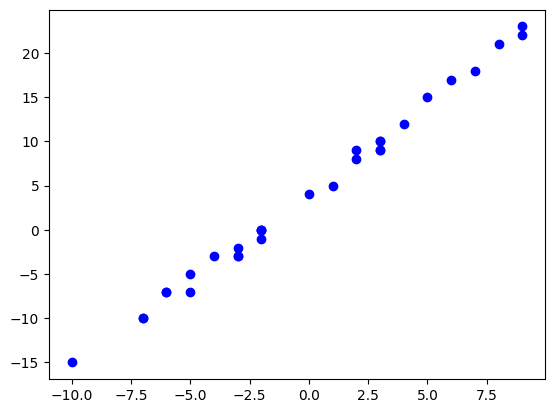

In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt

w = 2
b = 3
xlim = [-10, 10]
x_train = np.random.randint(low=xlim[0], high=xlim[1], size=30)

y_train = [w * x + b + random.randint(0,2) for x in x_train]

plt.plot(x_train, y_train, 'bo')

In [2]:
import torch
from torch import nn

class LinearModel(nn.Module):  #必须继承 nn.Module 类
  def __init__(self):
    super().__init__()
    #通常来说要把有需要学习的参数的层放到构造函数中
    self.weight = nn.Parameter(torch.randn(1))
    self.bias = nn.Parameter(torch.randn(1))

  def forward(self, input): #forward()前向传播 是必须重写的方法
    return (input * self.weight) + self.bias

In [3]:
model = LinearModel()
# 定义优化器
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, weight_decay=1e-2, momentum=0.9)  #优化器（Optimizer）就是一个根据梯度信息自动更新模型参数的算法。

y_train = torch.tensor(y_train, dtype=torch.float32) #把原本的 NumPy或Python数据（y_train）转成 PyTorch张量（Tensor），
for _ in range(1000):
    input = torch.from_numpy(x_train)
    output = model(input)
    loss = nn.MSELoss()(output, y_train)
    model.zero_grad()
    loss.backward()
    optimizer.step()

优化器：

| 参数名                  | 含义                 | 举例解释                         |
| -------------------- | ------------------ | ---------------------------- |
| `model.parameters()` | 告诉优化器要更新哪些参数       | 就是 model 的 `weight` 和 `bias` |
| `lr=1e-4`            | 学习率（learning rate） | 一次走多大步，下山步幅                  |
| `momentum=0.9`       | 动量                 | 让梯度更新更平滑，不会左右乱晃              |
| `weight_decay=1e-2`  | 权重衰减（L2正则化）        | 防止参数太大导致过拟合                  |


优化器的工作流程:

for _ in range(1000):

    output = model(input)         # 1️⃣ 前向传播
    
    loss = nn.MSELoss()(output, y_train)  # 2️⃣ 计算损失
    
    model.zero_grad()             # 3️⃣ 清空旧梯度
    
    loss.backward()               # 4️⃣ 反向传播，计算梯度
    
    optimizer.step()              # 5️⃣ 优化器更新参数 ✅


In [4]:
#model.named_parameters() 会遍历模型中所有可训练参数（learnable parameters）

for parameter in model.named_parameters():    
  print(parameter)

('weight', Parameter containing:
tensor([2.0042], requires_grad=True))
('bias', Parameter containing:
tensor([3.3131], requires_grad=True))


In [5]:
# 定义一个新的神经网络层：输入 → Conv2d(输入通道→3) → Conv2d(3→输出通道) → 输出


class CustomLayer(nn.Module):
  def __init__(self, input_channels, output_channels):
    super().__init__()
    self.conv1_1 = nn.Conv2d(in_channels=input_channels, out_channels=3, kernel_size=3, padding='same')
    self.conv1_2 = nn.Conv2d(in_channels=3, out_channels=output_channels, kernel_size=2, padding='same')
    
  def forward(self, input):
    x = self.conv1_1(input)
    x = self.conv1_2(x)
    return x
    

解释：

第一层卷积：

self.conv1_1 = nn.Conv2d(
    in_channels=input_channels,   # 输入特征图的通道数（如RGB是3）
    out_channels=3,               # 输出通道数=3
    kernel_size=3,                # 卷积核大小 3x3
    padding='same'                # 保持输入输出尺寸相同
)


👉 意思是：
第一个卷积层接收输入通道数为 input_channels（例如图像3通道），
输出3个通道的特征图。

padding='same' 表示自动补零，让输出尺寸和输入一样大。

第二层卷积

self.conv1_2 = nn.Conv2d(
    in_channels=3,                # 上一层输出通道=3
    out_channels=output_channels, # 输出通道=你设定的值
    kernel_size=2,
    padding='same'
)


👉 意思是：
第二层卷积从上一层的3个通道输入，
输出 output_channels 个通道的特征图（比如64、128等）。



def forward(self, input):
    x = self.conv1_1(input)   # 第一次卷积
    x = self.conv1_2(x)       # 第二次卷积
    return x


# 保存模型

## 只保存训练好的参数

In [6]:
torch.save(model.state_dict(), './linear_model.pth')   #第一个参数是模型的 state_dict，而第二个参数要保存的位置

代码中的 state_dict 是一个字典，在模型被定义之后会自动生成，存储的是模型可训练的参数。我们可以打印出线性回归模型的 state_dict，如下所示

In [7]:
model.state_dict()

OrderedDict([('weight', tensor([2.0042])), ('bias', tensor([3.3131]))])

加载模型的方式如下所示：

In [8]:
# 先定义网络结构
linear_model = LinearModel()
# 加载保存的参数
linear_model.load_state_dict(torch.load('./linear_model.pth'))
linear_model.eval()
for parameter in linear_model.named_parameters():
  print(parameter)

('weight', Parameter containing:
tensor([2.0042], requires_grad=True))
('bias', Parameter containing:
tensor([3.3131], requires_grad=True))


In [9]:
from torchvision import models
from torchvision.models import AlexNet_Weights

# 使用新写法加载预训练模型
alexnet = models.alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
# 或者使用默认权重
# alexnet = models.alexnet(weights=AlexNet_Weights.DEFAULT)


In [10]:
from PIL import Image
import torchvision
import torchvision.transforms as transforms

im = Image.open('dog.webp')

transform = transforms.Compose([
    transforms.RandomResizedCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

input_tensor = transform(im).unsqueeze(0)
alexnet(input_tensor).argmax()

tensor(264)

In [11]:
# 157类是什么

from torchvision.models import AlexNet_Weights

weights = AlexNet_Weights.IMAGENET1K_V1
categories = weights.meta["categories"]

print(categories[157])

papillon


In [12]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# 微调

In [ ]:
"""
PyTorch 微调（Fine-tuning）AlexNet 简单示例（含 Apple MPS 加速）
--------------------------------------------------
功能：
1. 使用 torchvision 自带的 AlexNet 预训练模型；
2. 冻结特征提取层（features），只训练分类器层；
3. 在 CIFAR-10 数据集上进行微调；
4. 优先使用 Apple MPS（Metal），其次 CUDA，最后 CPU；
5. 半精度 autocast（MPS/CUDA），自动下载数据与权重；
6. 保存微调后的模型。

运行环境（建议）：
pip install torch torchvision
"""

import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import alexnet, AlexNet_Weights
from contextlib import nullcontext

# ============================================================
# 1. 环境设置（优先使用 MPS，其次 CUDA）
# ============================================================
use_mps = torch.backends.mps.is_available() and torch.backends.mps.is_built()
if use_mps:
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print("Using device:", device)

# （可选）macOS 上 DataLoader 建议使用 spawn
try:
    import torch.multiprocessing as mp
    mp.set_start_method("spawn", force=True)
except RuntimeError:
    pass

# 是否启用 channels_last 加速（对 CNN 有时更快；若遇到不支持的算子可设为 False）
USE_CHANNELS_LAST = True

# ============================================================
# 2. 加载预训练模型并冻结特征提取层
# ============================================================
# 从官方加载 ImageNet 预训练的 AlexNet 权重
model = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)

# 冻结特征提取层的参数（即卷积部分 features）
for param in model.features.parameters():
    param.requires_grad = False

# 替换最后的全连接层，使输出类别数 = CIFAR10 的 10 类
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 10)

# 把模型放到相应设备
model = model.to(device)

# 可选：channels_last
if USE_CHANNELS_LAST and device != "cpu":
    model = model.to(memory_format=torch.channels_last)

# ============================================================
# 3. 数据准备（使用 AlexNet 权重自带的标准化参数）
# ============================================================
# 由于 AlexNet 是在 ImageNet 上训练的，输入大小应为 224×224
# transforms 包括 Resize、Crop、Normalize 等；权重自带的 transforms 含 ToTensor+Normalize
weight_tf = AlexNet_Weights.IMAGENET1K_V1.transforms()

train_tf = transforms.Compose([
    transforms.Resize(256),           # 调整短边到 256
    transforms.CenterCrop(224),       # 中心裁剪到 224×224
    transforms.RandAugment(),         # 随机数据增强（可删除以进一步提速）
    weight_tf,                        # 包含 ToTensor + Normalize
])
test_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    weight_tf,
])

# 自动下载 CIFAR10 数据集
data_root = "./data"
os.makedirs(data_root, exist_ok=True)
train_ds = datasets.CIFAR10(root=data_root, train=True, download=True, transform=train_tf)
test_ds  = datasets.CIFAR10(root=data_root, train=False, download=True, transform=test_tf)

# 创建数据加载器（pin_memory 对 CUDA 有效，MPS/CPU 下关闭）
pin = True if device == "cuda" else False
num_workers = 2  # 可根据 CPU 核心数调整（2~4 较合适）
batch_size_train = 64   # M 系列统一内存有限，如 OOM 可降到 32
batch_size_test  = 128  # 可酌情调整

train_loader = DataLoader(train_ds, batch_size=batch_size_train, shuffle=True,
                          num_workers=num_workers, pin_memory=pin)
test_loader  = DataLoader(test_ds,  batch_size=batch_size_test, shuffle=False,
                          num_workers=num_workers, pin_memory=pin)

# ============================================================
# 4. 定义优化器和损失函数
# ============================================================
# 只优化 requires_grad=True 的参数（分类器层）
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                              lr=2e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# ============================================================
# 5. AMP / autocast 上下文（MPS/CUDA 半精度）
# ============================================================
if device == "mps":
    autocast_ctx = torch.autocast(device_type="mps", dtype=torch.float16)
    scaler = None  # MPS 无需 GradScaler
elif device == "cuda":
    from torch.cuda.amp import autocast as cuda_autocast, GradScaler
    autocast_ctx = cuda_autocast(dtype=torch.float16)
    scaler = GradScaler()
else:
    autocast_ctx = nullcontext()
    scaler = None

# ============================================================
# 5+. 评估函数（计算平均损失和准确率）
# ============================================================
def evaluate(loader):
    model.eval()
    total_loss, total_acc, n = 0.0, 0.0, 0
    with torch.no_grad():
        for x, y in loader:
            # 可选 channels_last：仅在非 CPU 且启用时转换
            if USE_CHANNELS_LAST and device != "cpu":
                x = x.to(device, memory_format=torch.channels_last, non_blocking=pin)
            else:
                x = x.to(device, non_blocking=pin)
            y = y.to(device, non_blocking=pin)

            with autocast_ctx:
                logits = model(x)
                loss = criterion(logits, y)

            total_loss += float(loss.item()) * x.size(0)
            total_acc  += (logits.argmax(1) == y).float().sum().item()
            n += x.size(0)
    return total_loss / n, total_acc / n

# ============================================================
# 6. 训练循环
# ============================================================
epochs = 3  # 为了快速演示只跑 3 个 epoch，可自行调大
for epoch in range(1, epochs + 1):
    model.train()
    running_loss, running_acc, total = 0.0, 0.0, 0

    for images, labels in train_loader:
        # 可选 channels_last：仅在非 CPU 且启用时转换
        if USE_CHANNELS_LAST and device != "cpu":
            images = images.to(device, memory_format=torch.channels_last, non_blocking=pin)
        else:
            images = images.to(device, non_blocking=pin)
        labels = labels.to(device, non_blocking=pin)

        optimizer.zero_grad(set_to_none=True)

        # 前向 + 计算 loss（半精度）
        with autocast_ctx:
            outputs = model(images)
            loss = criterion(outputs, labels)

        # 反向传播与参数更新（CUDA 用 GradScaler，MPS/CPU 直接 backward）
        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        # 统计训练准确率与损失
        running_loss += float(loss.item()) * images.size(0)
        running_acc  += (outputs.argmax(1) == labels).float().sum().item()
        total += images.size(0)

    train_loss = running_loss / total
    train_acc  = running_acc / total
    val_loss, val_acc = evaluate(test_loader)

    print(f"Epoch {epoch}/{epochs} | "
          f"train_loss={train_loss:.4f} acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f} acc={val_acc:.4f}")

# ============================================================
# 7. 可选：解冻部分卷积层进一步精调
# ============================================================
# 常见策略：先冻结特征层，稳定分类器；再解冻后几层继续训练（效果更好）
# for param in model.features[6:].parameters():
#     param.requires_grad = True
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
# 再跑若干 epoch ...

# ============================================================
# 8. 保存模型权重
# ============================================================
save_path = "alexnet_cifar10_finetuned.pth"
torch.save(model.state_dict(), save_path)
print(f"✅ 模型已保存到 {save_path}")


Using device: mps
Epoch 1/3 | train_loss=1.0278 acc=0.6336 | val_loss=0.6252 acc=0.7785
